In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import optimize, stats
import pandas as pd
import sympy as smp
import requests
from io import StringIO
from IPython.display import display, Math, Markdown, HTML
pd.set_option('display.max_colwidth', None)

# Gather OP data related to Cleo

## Import Data on Users Cleo Answered to Using StackExchange API

In [2]:
user_id = 178256

In [3]:
cleo_json = requests.get(f"https://api.stackexchange.com/2.3/users/{user_id}/answers?pagesize=100&site=mathematics")
cleo_answers = pd.read_json(StringIO(cleo_json.text))
cleo_answers = pd.json_normalize(cleo_answers.loc[:, "items"])

# Info about the questions
q_ids = ";".join([str(i) for i in cleo_answers["question_id"]])
questions = requests.get(f"https://api.stackexchange.com/2.2/questions/{q_ids}?pagesize=100&site=mathematics")
questions_t = pd.read_json(StringIO(questions.text))
df_questions = pd.json_normalize(questions_t.loc[:, "items"])

## Clean OP Data

In [4]:
df_OPall = df_questions[['owner.display_name', 'owner.reputation', 'owner.user_id', 'owner.link']].drop_duplicates()
df_OPall.sort_values('owner.reputation', ascending=False, inplace=True)
df_OPall.rename(columns={'owner.display_name': 'Username', 'owner.reputation': 'Reputation', 'owner.user_id': 'ID', 'owner.link': 'Profile Link'}, inplace=True, )
df_OPall = df_OPall.reset_index(drop=True)

cleo_list = [cleo_answers['owner.display_name'][0], cleo_answers['owner.reputation'][0], cleo_answers['owner.user_id'][0], cleo_answers['owner.link'][0]]
df_OPall.loc[len(df_OPall)] = cleo_list

# Import data function

In [5]:
def get_data_by_user_id(ID, type1, type2):
    data = []
    page = 1
    has_more = True

    while has_more:
        url = f"https://api.stackexchange.com/2.3/{type1}/{ID}/" + type2
        params = {
            "order": "desc",
            "sort": "activity",
            "site": "math",
            "page": page,
            "pagesize": 100  
        }
        response = requests.get(url, params=params)
        response = response.json()

        if "items" in response:
            data.extend(response["items"])
            has_more = response["has_more"]
            page += 1
        else:
            has_more = False

    return data

def get_data(ID, type1, type2):
    all_data = []
    for ID in ID:
        data_tmp = get_data_by_user_id(ID, type1, type2)
        all_data.extend(data_tmp)
    return all_data

# Questions and Answers

## OP Question Data

In [6]:
ids = [int(n) for n in df_OPall['ID'].dropna().to_list()]

mid_index = len(ids) // 2

first_half_ids = ids[:mid_index]
second_half_ids = ids[mid_index:] 

first_half_data = get_data(first_half_ids, 'users', 'questions')

In [7]:
second_half_data = get_data(second_half_ids, 'users', 'questions')

combined_data = first_half_data + second_half_data

df_OPquestions = pd.DataFrame(combined_data)

In [8]:
# Extract display_name and user_id from the owner column
df_OPquestions['owner_display_name'] = df_OPquestions['owner'].apply(lambda x: x.get('display_name') if isinstance(x, dict) else None)
df_OPquestions['owner_user_id'] = df_OPquestions['owner'].apply(lambda x: x.get('user_id') if isinstance(x, dict) else None)

# Drop the original 'owner' column if not needed
df_OPquestions = df_OPquestions.drop(columns=['owner'])
df_OPquestions = df_OPquestions[['owner_display_name', 'owner_user_id', 'title', 'creation_date', 'link']]
df_OPquestions = df_OPquestions.sort_values(['owner_display_name', 'creation_date'], ascending=[True, False])

# Rename columns
df_OPquestions.rename(columns={
    'owner_display_name': 'Username',
    'creation_date': 'Post Date',
    'owner_user_id': 'ID',
    'title': 'Post Title',
    'link': 'Post Link'
}, inplace=True)

# Convert Unix timestamps to dates
df_OPquestions['Post Date'] = pd.to_datetime(df_OPquestions['Post Date'], unit='s').dt.strftime('%d-%m-%Y %H:%M')

## OP Answer Data

In [9]:
# Importing Answer data
OPanswers = get_data([int(n) for n in df_OPall['ID'].dropna().to_list()], 'users', 'answers')
df_OPanswers_tmp = pd.DataFrame(OPanswers)

In [10]:
# Extract display_name and user_id from the owner column
df_OPanswers = df_OPanswers_tmp
df_OPanswers['owner_display_name'] = df_OPanswers['owner'].apply(lambda x: x.get('display_name') if isinstance(x, dict) else None)
df_OPanswers['owner_user_id'] = df_OPanswers['owner'].apply(lambda x: x.get('user_id') if isinstance(x, dict) else None)

# Drop the original 'owner' column if not needed
df_OPanswers = df_OPanswers[['owner_display_name', 'owner_user_id', 'answer_id', 'creation_date', 'question_id']]
df_OPanswers = df_OPanswers.sort_values(['owner_display_name', 'creation_date'], ascending=[True, False])

# Rename columns
df_OPanswers.rename(columns={
    'owner_display_name': 'Username',
    'creation_date': 'Post Date',
    'owner_user_id': 'ID',
}, inplace=True)

# Convert Unix timestamps to dates
df_OPanswers['Post Date'] = pd.to_datetime(df_OPanswers['Post Date'], unit='s').dt.strftime('%d-%m-%Y %H:%M')

# Timeline

In [11]:
df_OPquestions['Post Date'] = pd.to_datetime(df_OPquestions['Post Date'], format="%d-%m-%Y %H:%M")
df_OPanswers['Post Date'] = pd.to_datetime(df_OPanswers['Post Date'], format="%d-%m-%Y %H:%M")

In [12]:
def get_OPdata(username=None, type=None):
    if not username and not type:
        return df_OPall
    elif type == 'Q':
        return df_OPquestions[df_OPquestions['Username'] == username]
    
    elif type == 'A':
        if 'answer_url' and 'Answer URL' not in df_OPanswers.columns:
            def make_url(username, answer_id):
                user = username.replace(' ', '-')
                link = 'https://math.stackexchange.com/questions/' + answer_id
                return link
            df_OPanswers['answer_url'] = df_OPanswers.apply(lambda row: make_url(row['Username'], str(row['answer_id'])), axis=1)
            df_OPanswers.to_html('table_with_links.html', columns=['Username', 'answer_url'], escape=False)
            df_OPanswers.rename(columns={'answer_url': 'Answer URL'}, inplace=True)

        return df_OPanswers[df_OPanswers['Username'] == username].drop(columns='answer_id')

In [13]:
import warnings

def plot_timeline(questions, answers, start=None, end=None, figsize=(15, 10), title='Timeline'):
    marker_size = 8

    plt.figure(figsize=figsize, dpi=200)
    # Suppress specific warnings
    warnings.filterwarnings("ignore", message="Glyph .* missing from current font")
    
    for username in questions['Username'].unique():
        user_data = questions[questions['Username'] == username]
        plt.scatter(user_data['Post Date'], [username]*len(user_data), color='red', s=marker_size, label='Questions' if username == questions['Username'].unique()[0] else "")
    
    for username in answers['Username'].unique():
        user_data = answers[answers['Username'] == username]
        plt.scatter(user_data['Post Date'], [username]*len(user_data), color='blue', s=marker_size, label='Answers' if username == answers['Username'].unique()[0] else "")
    
    plt.xlabel('Date')
    plt.ylabel('Username')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Questions')
    blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Answers')
    plt.legend(handles=[red_patch, blue_patch])
    
    if start and end:
        plt.xlim(pd.Timestamp(start), pd.Timestamp(end))
    plt.grid(axis='y', linestyle='-', linewidth=0)
    plt.grid()
    plt.show()

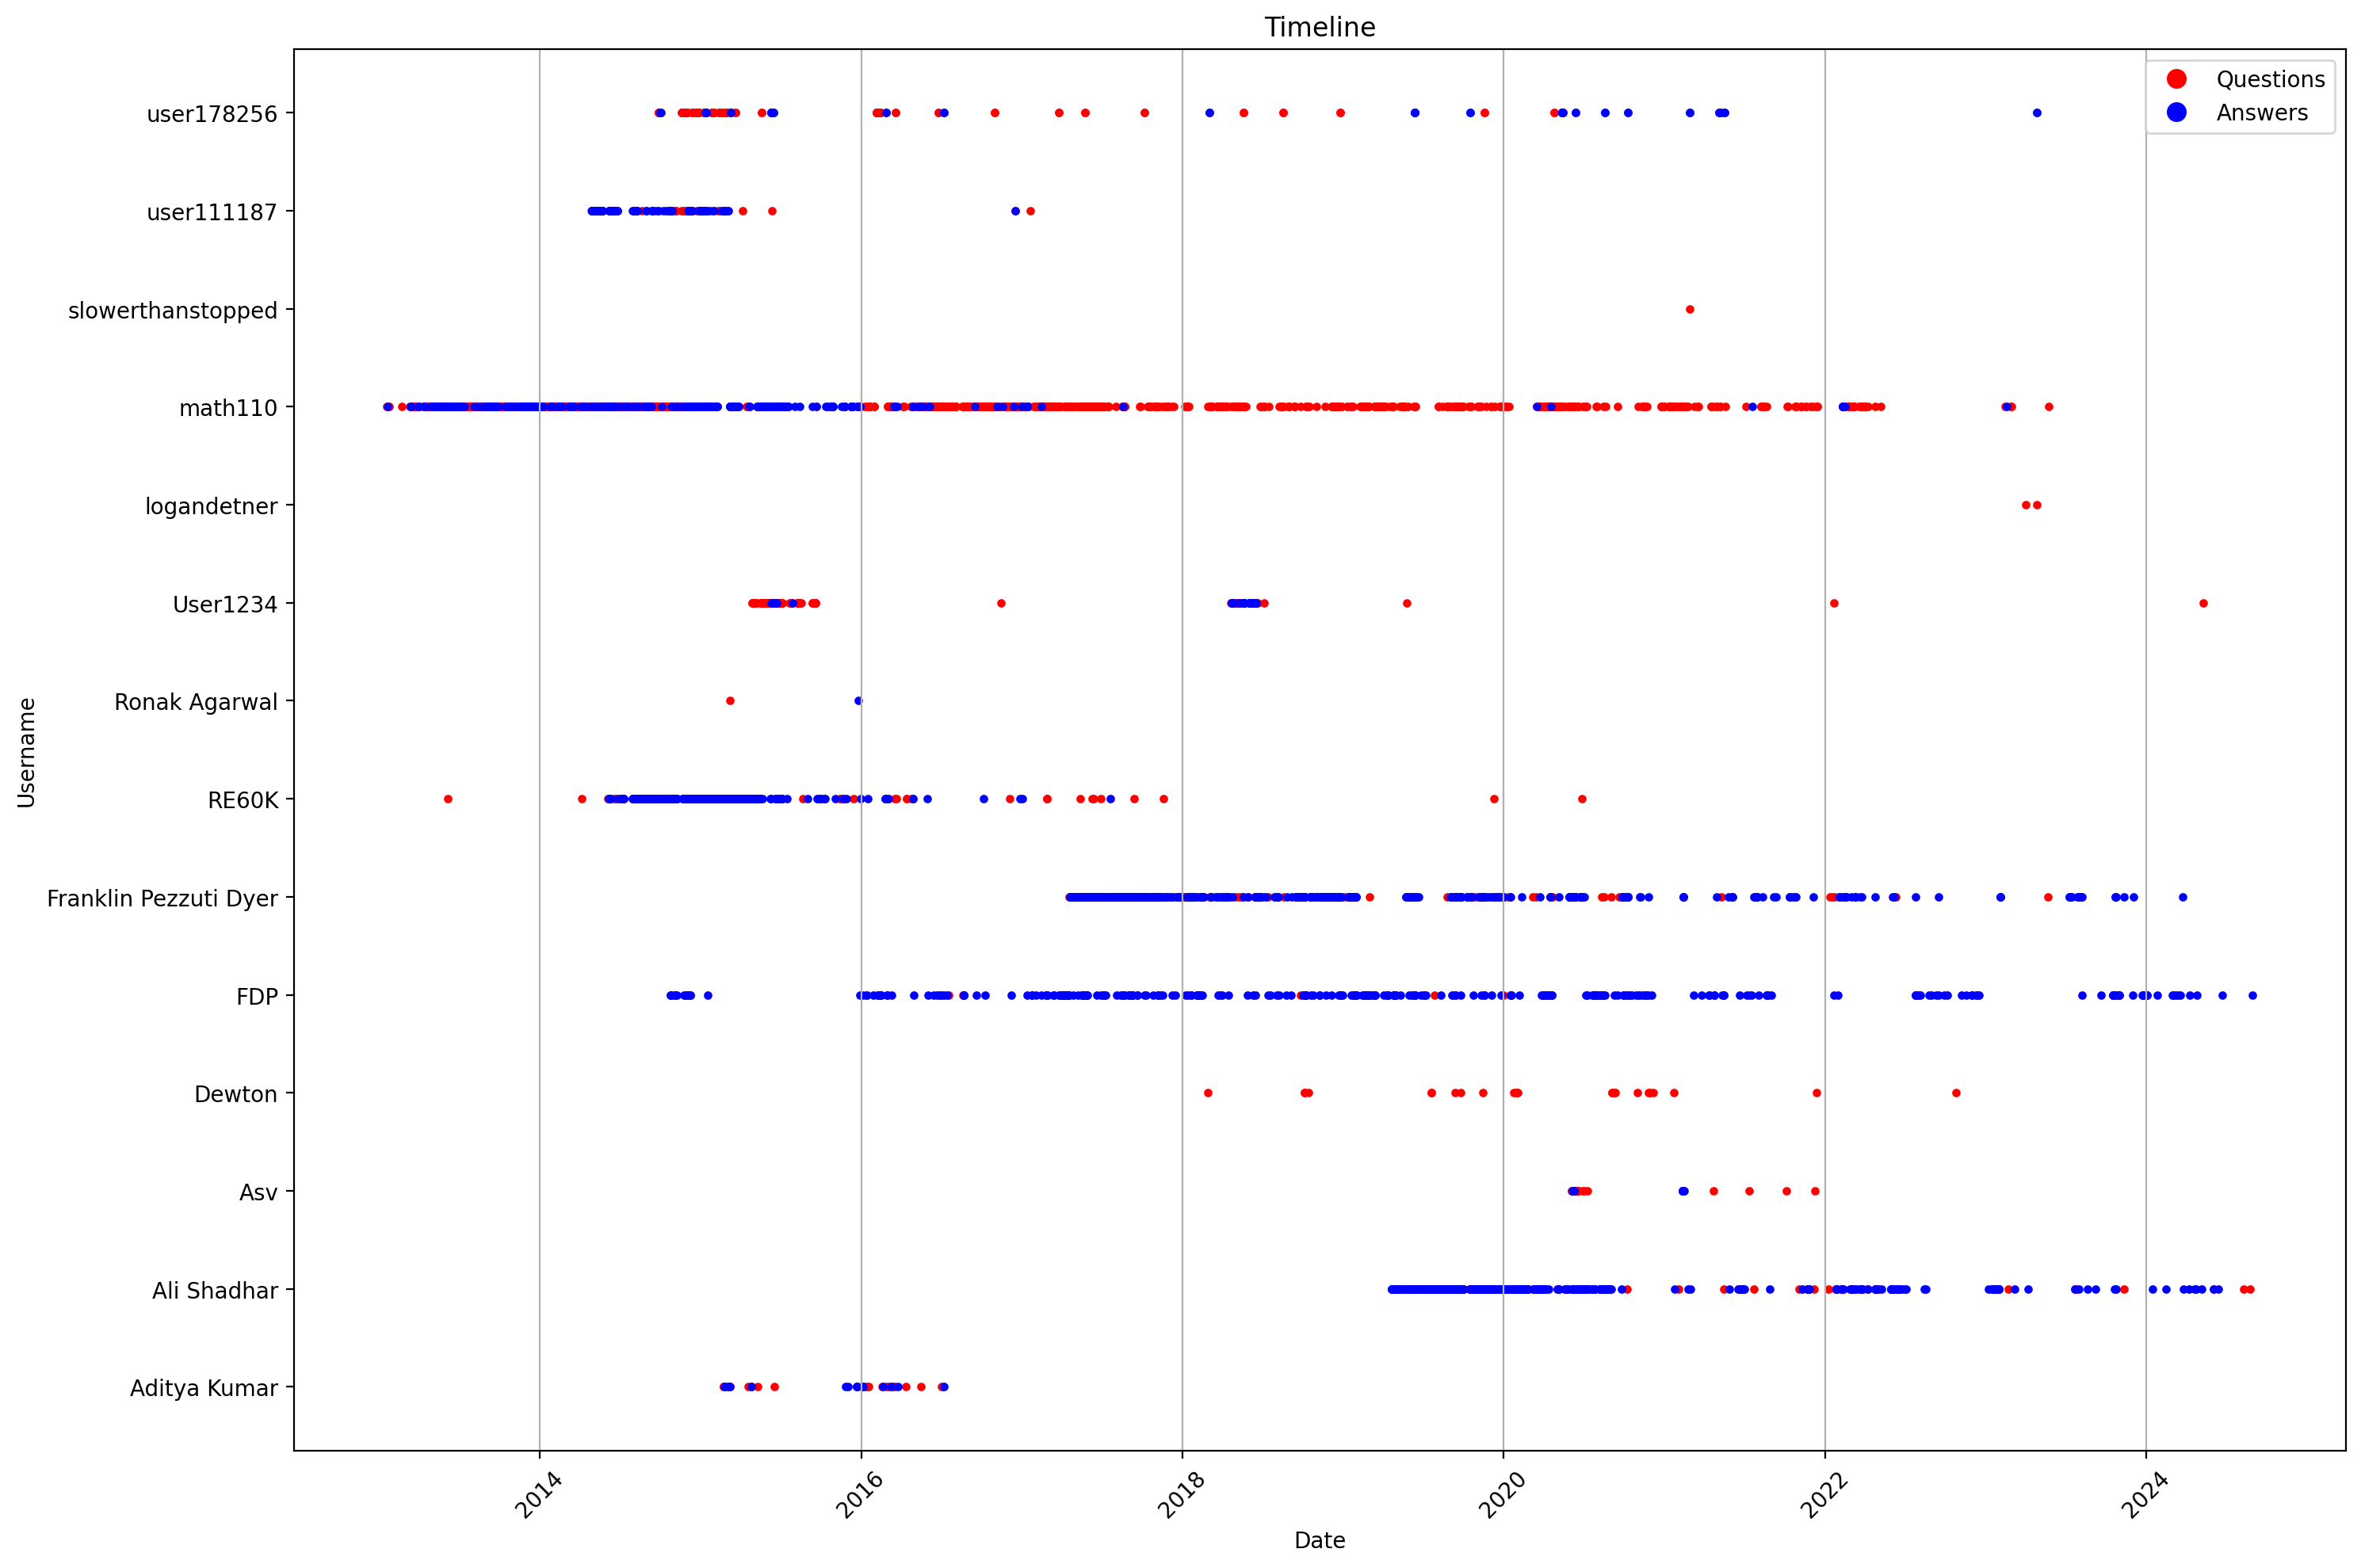

In [14]:
plot_timeline(df_OPquestions, df_OPanswers)

In [15]:
df_OPanswers.to_csv(f'answers_{user_id}.csv', index=False)
df_OPquestions.to_csv(f'questions_{user_id}.csv', index=False)

In [16]:
df_OPall

,Username,Reputation,ID,Profile Link
0,math110,93704.0,58742.0,https://math.stackexchange.com/users/58742/math110
1,Franklin Pezzuti Dyer,40063.0,438055.0,https://math.stackexchange.com/users/438055/franklin-pezzuti-dyer
2,Ali Shadhar,26155.0,432085.0,https://math.stackexchange.com/users/432085/ali-shadhar
3,RE60K,17756.0,67609.0,https://math.stackexchange.com/users/67609/re60k
4,FDP,14088.0,186817.0,https://math.stackexchange.com/users/186817/fdp
5,user111187,5856.0,111187.0,https://math.stackexchange.com/users/111187/user111187
6,user178256,5567.0,178256.0,https://math.stackexchange.com/users/178256/user178256
7,User1234,4126.0,235058.0,https://math.stackexchange.com/users/235058/user1234
8,Aditya Kumar,1549.0,218324.0,https://math.stackexchange.com/users/218324/aditya-kumar
9,Asv,510.0,795503.0,https://math.stackexchange.com/users/795503/asv
